In [5]:
import math
import torch
import gpytorch
from torch.nn.functional import softplus
import pandas as pd
import requests
import time
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '/mtsgp/')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from sdtw_div.numba_ops import sdtw_div, sdtw_div_value_and_grad
from python.util2 import plotts, ccf
from python.utils import preprocess
from python.GPlag import MTSE, GPModel, train_adam, MTSGP
from fastdtw import dtw
from tslearn.metrics import soft_dtw


/nas/longleaf/home/wancen/.conda/envs/GP/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [6]:
houseprice = pd.read_csv("/proj/milovelab/mu/lima/data/weeklyprice_filtered.tsv", sep = "\t")

In [7]:
# column_names_list = houseprice.columns.tolist()
# column_names_list
houseprice['median_sale_price'] = houseprice['median_sale_price'].fillna(0)
houseprice['inventory'] = houseprice['inventory'].fillna(0)
houseprice = houseprice.sort_values('period_end')
unique_regions = houseprice['region_name'].unique()


In [ ]:
houseprice_process2 = preprocess(houseprice, '2022-01-01', '2022-10-01', "Raleigh, NC metro area")
houseprice_process = preprocess(houseprice, '2022-01-01', '2022-10-01', "Greenville, NC metro area")

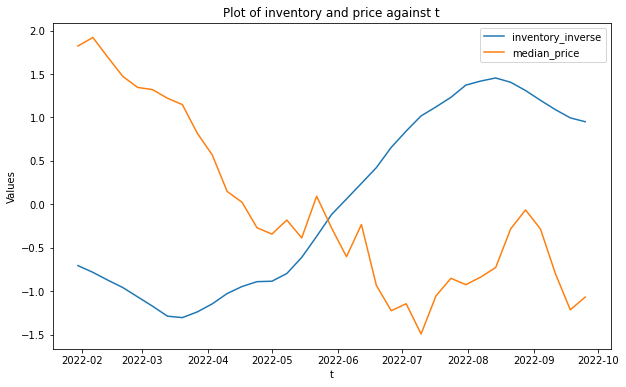

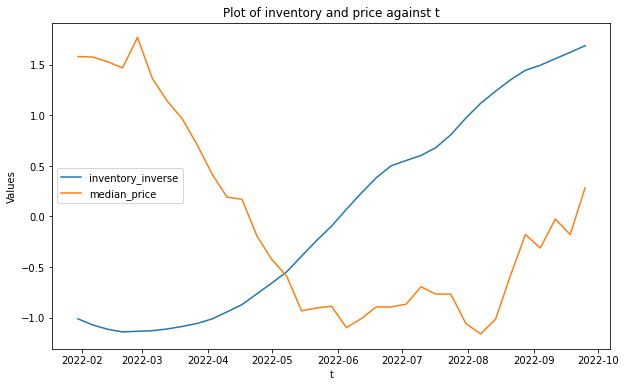

In [13]:
plotts(houseprice_process)
plotts(houseprice_process2)

In [26]:
t = houseprice_process['days']
train_x = torch.tensor(np.concatenate((t, t)), dtype=torch.float32)
x1 = houseprice_process['inventory_inverse_scaled']
x2 = houseprice_process['price_scaled']
# print(x2)
train_y = torch.tensor(np.concatenate((x1, x2)), dtype=torch.float32)
n = houseprice_process.shape[0]
# print(x1)
# print(x2)

In [ ]:
dtwloss = []
softdtwloss = []
softdtwdiv = []
ccfcoef = []
ccfshift = []
alpha_mle = []
timelag_mle = []
for i in unique_regions:
    # print(i)
    houseprice_process = preprocess(houseprice, '2022-01-01', '2022-10-01', i)
    if isinstance(houseprice_process, int) and houseprice_process == 0:
        softdtwloss.append(None)
        dtwloss.append(None)
        softdtwdiv.append(None)
        ccfcoef.append(None)
        ccfshift.append(None)
        alpha_mle.append(None)
        timelag_mle.append(None)
        continue
    
    t = houseprice_process['days']
    train_x = torch.tensor(np.concatenate((t, t)), dtype=torch.float32)
    x1 = houseprice_process['inventory_inverse_scaled'].tolist()
    x2 = houseprice_process['price_scaled'].tolist()
    train_y = torch.tensor(np.concatenate((x1, x2)), dtype=torch.float32)
    n = houseprice_process.shape[0]
    distance, path = dtw(x1, x2)
    indices_1 = [index_1 for index_1, index_2 in path]
    indices_2 = [index_2 for index_1, index_2 in path]
    aligned_series_1 = [x1[index] for index in indices_1]
    aligned_series_2 = [x2[index] for index in indices_2]
    correlation = np.corrcoef(aligned_series_1, aligned_series_2)[0, 1]
    dtwloss.append(correlation)

    softdistance = soft_dtw(x1, x2)
    softdtwloss.append(softdistance)

    y1 = houseprice_process['inventory_inverse_scaled'].values.reshape(-1, 1)
    y2 = houseprice_process['price_scaled'].values.reshape(-1, 1)
    value = sdtw_div(y1, y2, gamma=1.0)
    softdtwdiv.append(value)
    
    maxlag = 20
    ccf_values = ccf(x1, x2, 20)
    ccfcoef.append(max(ccf_values))
    max_shift = np.argmax(ccf_values) - maxlag
    ccfshift.append(max_shift)
    
    # train_y = torch.cat((y1_standardized, y2_standardized), dim=0)
# Create a Gaussian likelihood
    likelihood = gpytorch.likelihoods.GaussianLikelihood()

    # Create the GP model with the custom kernel
    my_kernel = MTSE(sigma=1, alpha = 0.2, length=0.5, timelag_init_value = -90, timelag_lower_bound=-200, timelag_upper_bound=max_shift*7+100)
    model = MTSGP(train_x, train_y, likelihood, my_kernel)

    # Move the model and likelihood to the appropriate device (CPU or GPU)
    model = model.to(device)
    likelihood = likelihood.to(device)

    # Set the model and likelihood to training mode
    model.train()
    likelihood.train()
    train_adam(model, likelihood, train_x=train_x, train_y=train_y, n1=n, n2=n, lr = 0.15, training_iter= 200)
    alpha_mle.append(model.covar_module.alpha.item())
    timelag_mle.append(model.covar_module.raw_timelag.item())


In [15]:
df = pd.DataFrame({
    'region_name' : unique_regions,
    'dtwloss': dtwloss,
    'softdtwloss': softdtwloss,
    'softdtwdiv': softdtwdiv,
    'ccfcoef': ccfcoef,
    'ccfshift': ccfshift,
    'alpha2' : alpha_mle,
    'timelag2' : timelag_mle
})
df.to_csv('/proj/milovelab/mu/lima/data/baselineprice2.csv', index = False)

In [13]:
distance, path = dtw(x1, x2)
print("DTW distance:", distance)
print("DTW distance:", path)
distance = soft_dtw(x1.tolist(), x2.tolist())

print("soft-DTW distance:", distance)

DTW distance: 10.015410527763217
DTW distance: [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 4), (6, 5), (7, 6), (8, 6), (9, 6), (10, 7), (11, 8), (12, 8), (13, 9), (13, 10), (13, 11), (13, 12), (13, 13), (13, 14), (13, 15), (13, 16), (14, 17), (15, 18), (15, 19), (16, 20), (16, 21), (16, 22), (16, 23), (16, 24), (16, 25), (16, 26), (17, 27), (18, 28), (19, 29), (20, 29), (21, 29), (22, 30), (23, 31), (24, 32), (25, 32), (26, 33), (27, 33), (28, 33), (29, 33), (30, 33), (31, 33), (32, 33), (33, 33), (34, 34)]
soft-DTW distance: -41.542433807548704
